# Deep Convolutional GANs

In this notebook, we'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

We'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

A subdirectory or file data already exists.


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

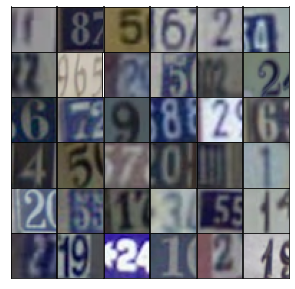

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5))

for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    # x = ((x - x.min())/(255 - x.min()))
    
    # # scale to feature_range
    # min, max = feature_range
    # x = x * (max - min) + min

    x = (x - 127.5) / 127.5

    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.1, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Generator

Here we'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output (therefore output in the range -1,+1), but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:
<center><img src="assets/dcgan.png", width="500" height="200"/></center>
Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 


In [8]:
from tensorflow.keras import layers

In [9]:

def generator(alpha=0.2):
    model = tf.keras.Sequential()

    # Input to 3D cube reshape
    model.add(layers.Dense(4*4*512, input_shape=(100,)))
    model.add(layers.Reshape((4,4,512)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))

    model.add(layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))
    
    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))

    model.add(layers.Conv2DTranspose(32, (5,5), strides=(2,2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))

    model.add(layers.Conv2DTranspose(8, (5,5), strides=(1,1), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))
    
    model.add(layers.Conv2DTranspose(3, (5,5), strides=(1,1), padding="same", activation="tanh"))
    
    return model

In [10]:
# g = generator()
# noise = tf.random.normal([1, 100])
# generated_image = g(noise, training=False)

# plt.imshow(np.array(generated_image[0]*127.5 + 127.5, dtype=np.int32))

# # g.summary()

## Discriminator

Here we'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.


In [11]:
def discriminator(alpha=0.2):

    model = tf.keras.Sequential()

    # Input to 3D cube reshape
    model.add(layers.Conv2D(8, kernel_size=(5,5), strides=(1,1), padding="same", input_shape=(32,32,3)))
    model.add(layers.Conv2D(32, kernel_size=(5,5), strides=(2,2), padding="same"))
    model.add(layers.LeakyReLU(alpha))

    model.add(layers.Conv2D(64, kernel_size=(5,5), strides=(2,2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))

    model.add(layers.Conv2D(256, kernel_size=(5,5), strides=(2,2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))

    model.add(layers.Conv2D(512, kernel_size=(5,5), strides=(2,2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    
    return model

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

Here is a function for displaying generated images.

In [12]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [15]:
# Load the data and train the network here
dataset = Dataset(trainset, testset, scale_func=scale)

In [16]:
# generator_optimizer = tf.keras.optimizers.Adam(0.00002, beta_1=0.6)
# discriminator_optimizer = tf.keras.optimizers.Adam(0.001)

generator_optimizer = tf.keras.optimizers.Adam(0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0005)

In [17]:
generator_model = generator()
discriminator_model = discriminator()

Batch gen-loss=1.1950774192810059 disc_loss=1.5867098569869995
Batch gen-loss=0.015850180760025978 disc_loss=4.823945999145508
Batch gen-loss=15.193769454956055 disc_loss=0.15686678886413574
Batch gen-loss=20.485340118408203 disc_loss=0.37961825728416443
Batch gen-loss=19.576173782348633 disc_loss=0.2645820379257202
Batch gen-loss=14.054692268371582 disc_loss=0.3937784433364868
Batch gen-loss=1.8019917011260986 disc_loss=1.103969693183899
Batch gen-loss=8.855790138244629 disc_loss=0.02078927308320999
Batch gen-loss=14.121094703674316 disc_loss=0.022686509415507317
Batch gen-loss=16.167388916015625 disc_loss=0.0020776463206857443
Batch gen-loss=15.956876754760742 disc_loss=0.01591787487268448
Batch gen-loss=13.761834144592285 disc_loss=0.037125010043382645
Batch gen-loss=9.330281257629395 disc_loss=0.02849755808711052
Batch gen-loss=3.360219955444336 disc_loss=0.4613724946975708
Batch gen-loss=12.305010795593262 disc_loss=0.051883596926927567
Batch gen-loss=16.652341842651367 disc_loss=

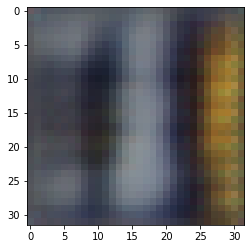

In [18]:
batch_size = 256
epochs = 25

losses = []
samples = []

for e in range(epochs):

    for x in dataset.batches(batch_size):

        noise = tf.random.normal([batch_size, 100])  # Z input

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

            generated_images = generator_model(noise, training=True)

            real_output = discriminator_model(x, training=True)
            fake_output = discriminator_model(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        
        gradients_of_generator = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))
        print(f"Batch gen-loss={gen_loss} disc_loss={disc_loss}")
        losses.append((disc_loss, gen_loss))

    noise = tf.random.normal([16, 100])
    predictions = generator_model(noise, training=False)
    print(f"Batch gen-loss={gen_loss} disc_loss={disc_loss}")
    plt.imshow(np.array((predictions[-1]*127.5 + 127.5), dtype=np.int32))

    samples.append(predictions.numpy())

    losses.append((disc_loss, gen_loss))

    print(f"Epoch {e+1} completed!")


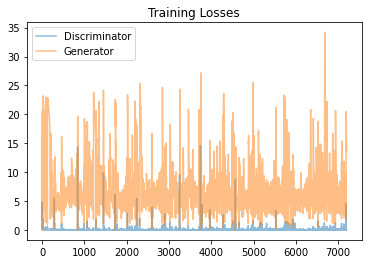

In [19]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [20]:
def view_samples(samples, nrows, ncols,  epoch=-1 ,figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    samples = samples[epoch]

    for ax, img in zip(axes.flatten(), samples):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        # img = np.array((img*127.5 + 127.5),dtype=np.int32)
        ax.set_adjustable('box')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

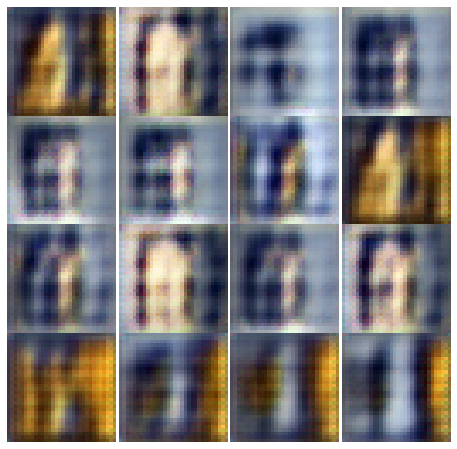

In [21]:
_ = view_samples(samples, 4, 4, figsize=(8,8), epoch=-1)

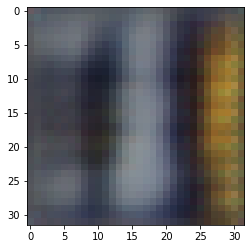

In [22]:
x = plt.imshow(np.array((samples[-1][-1]*127.5 + 127.5),dtype=np.int32))
